In [88]:
#Imports + Settings
import os
import re 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json

In [89]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier



In [90]:
!pip install tensorflow


In [91]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [92]:
!pip install nltk

In [93]:
import nltk
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abed\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abed\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\abed\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [94]:
# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [95]:
print("TensorFlow:", tf.__version__)

TensorFlow: 2.20.0


In [96]:
#Load Dataset
TRAIN_PATH = r"C:\Users\abed\Desktop\train.csv"
df=pd.read_csv(TRAIN_PATH)
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [97]:
#Define Labels + Basic Checks
LABELS = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
print("Shape:", df.shape)

Shape: (159571, 8)


In [98]:
print("Missing comment_text:", df['comment_text'].isna().sum())

Missing comment_text: 0


In [99]:
# Ensure labels exist
for col in LABELS:
    assert col in df.columns, f"Missing label column: {col}"

df[LABELS].sum().sort_values(ascending=False)

toxic            15294
obscene           8449
insult            7877
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64

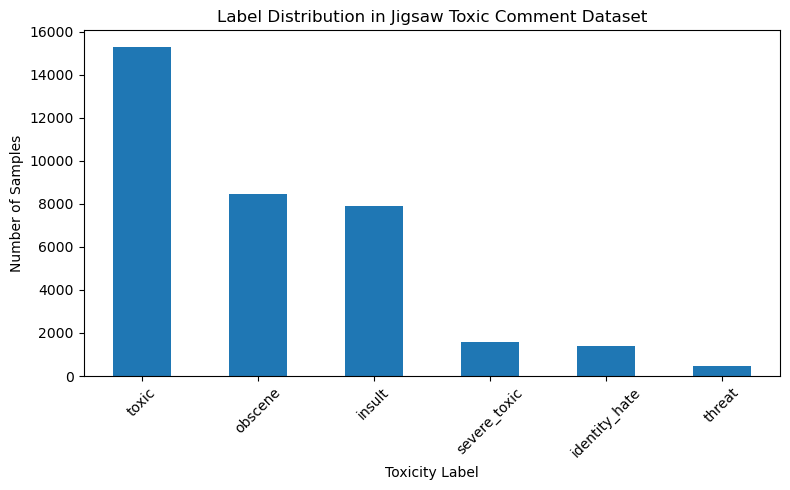

toxic            15294
obscene           8449
insult            7877
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64

In [100]:
#Exploratory Data Analysis (Label Distribution)
label_counts = df[LABELS].sum().sort_values(ascending=False)
plt.figure(figsize=(8,5))
label_counts.plot(kind='bar')
plt.title("Label Distribution in Jigsaw Toxic Comment Dataset")
plt.ylabel("Number of Samples")
plt.xlabel("Toxicity Label")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

label_counts

In [101]:
#Text Cleaning Function
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()

    # Remove URLs
    text = re.sub(r"http\S+|www\S+", "", text)

    # Remove HTML tags
    text = re.sub(r"<.*?>", "", text)

    # Keep only letters
    text = re.sub(r"[^a-z\s]", "", text)

    # Tokenize
    tokens = text.split()

    # Remove stopwords + lemmatize
    tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in stop_words
    ]

    return " ".join(tokens)

df["clean_comment"] = df["comment_text"].apply(clean_text)
df[["comment_text", "clean_comment"]].head()

,comment_text,clean_comment
0,Explanation\nWhy the edits made under my usern...,explanation edits made username hardcore metal...
1,D'aww! He matches this background colour I'm s...,daww match background colour im seemingly stuc...
2,"Hey man, I'm really not trying to edit war. It...",hey man im really trying edit war guy constant...
3,"""\nMore\nI can't make any real suggestions on ...",cant make real suggestion improvement wondered...
4,"You, sir, are my hero. Any chance you remember...",sir hero chance remember page thats


In [102]:
#Train/Test Split
X = df["clean_comment"].values
y = df[LABELS].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=SEED
)

In [103]:
print("Train size:", len(X_train))

Train size: 135635


In [104]:
print("Test size :", len(X_test))

Test size : 23936


In [105]:
#PART A: BASELINE MODEL (TF-IDF + Logistic Regression)

In [106]:
#TF-IDF Vectorization
tfidf = TfidfVectorizer(
    max_features=30000,
    ngram_range=(1,2),
    min_df=2
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [107]:
X_train_tfidf.shape, X_test_tfidf.shape

((135635, 30000), (23936, 30000))

In [108]:
#Train Baseline Mode
baseline_model = OneVsRestClassifier(
    LogisticRegression(max_iter=300, class_weight="balanced")
)

baseline_model.fit(X_train_tfidf, y_train)
print("Baseline training done.")

Baseline training done.


In [109]:
#Baseline Evaluation
y_pred_base = baseline_model.predict(X_test_tfidf)

print("===== BASELINE (TF-IDF + LogisticRegression) =====")
print("Macro F1:", f1_score(y_test, y_pred_base, average="macro"))



===== BASELINE (TF-IDF + LogisticRegression) =====
Macro F1: 0.53441843104727


In [110]:
print("\nPer-label report:")
print(classification_report(y_test, y_pred_base, target_names=LABELS, zero_division=0))



Per-label report:
               precision    recall  f1-score   support

        toxic       0.62      0.86      0.72      2260
 severe_toxic       0.24      0.80      0.37       225
      obscene       0.67      0.89      0.77      1279
       threat       0.20      0.75      0.31        53
       insult       0.54      0.87      0.67      1192
identity_hate       0.24      0.76      0.36       227

    micro avg       0.54      0.86      0.66      5236
    macro avg       0.42      0.82      0.53      5236
 weighted avg       0.58      0.86      0.69      5236
  samples avg       0.06      0.08      0.07      5236



In [111]:
#save Baseline Outputs
os.makedirs("outputs", exist_ok=True)

# Save vectorizer + model using joblib
joblib.dump(tfidf, "outputs/tfidf_vectorizer.joblib")
joblib.dump(baseline_model, "outputs/baseline_logreg_ovr.joblib")

# Save predictions
base_pred_df = pd.DataFrame(y_pred_base, columns=[f"pred_{c}" for c in LABELS])
base_pred_df.to_csv("outputs/baseline_predictions.csv", index=False)

print("Saved baseline artifacts to outputs/")


Saved baseline artifacts to outputs/


In [112]:
#PART B: DEEP LEARNING MODEL (BiLSTM)

In [113]:
#Tokenization + Padding
MAX_WORDS = 50000
MAX_LEN = 160

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq  = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post", truncating="post")
X_test_pad  = pad_sequences(X_test_seq,  maxlen=MAX_LEN, padding="post", truncating="post")

X_train_pad.shape, X_test_pad.shape


((135635, 160), (23936, 160))

In [114]:

# ---------- Oversampling Function ----------
def oversample_multilabel(
    X, y, labels,
    label_multipliers=None,
    seed=42
):
    """
    Random oversampling for multi-label text classification.
    Duplicates training samples that contain selected rare labels.
    label_multipliers example:
      {"threat": 6, "identity_hate": 5, "severe_toxic": 3}
    """
    if label_multipliers is None:
        label_multipliers = {"threat": 6, "identity_hate": 5, "severe_toxic": 3}

    rng = np.random.default_rng(seed)
    label_to_idx = {lab: i for i, lab in enumerate(labels)}
    base_idx = np.arange(len(X))
    extra_idx = []

    for lab, mult in label_multipliers.items():
        j = label_to_idx[lab]
        pos_idx = base_idx[y[:, j] == 1]
        if len(pos_idx) == 0:
            print(f"Warning: no positives for {lab}")
            continue
        sampled = rng.choice(pos_idx, size=len(pos_idx) * mult, replace=True)
        extra_idx.append(sampled)

    if extra_idx:
        all_idx = np.concatenate([base_idx, np.concatenate(extra_idx)])
    else:
        all_idx = base_idx

    rng.shuffle(all_idx)
    return X[all_idx], y[all_idx]


# ✅ APPLY OVERSAMPLING (TRAIN ONLY)
label_multipliers = {"threat": 6, "identity_hate": 5, "severe_toxic": 3}
X_train_os, y_train_os = oversample_multilabel(X_train_pad, y_train, LABELS, label_multipliers=label_multipliers)

print("Train size before:", X_train_pad.shape[0])
print("Train size after :", X_train_os.shape[0])

for lab in ["threat","identity_hate","severe_toxic"]:
    j = LABELS.index(lab)
    print(lab, "positives before:", int(y_train[:, j].sum()), "after:", int(y_train_os[:, j].sum()))




Train size before: 135635
Train size after : 148185
threat positives before: 425 after: 3740
identity_hate positives before: 1178 after: 8418
severe_toxic positives before: 1370 after: 7490


In [115]:
#Build BiLSTM Model (Multi-label)
model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=MAX_LEN),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(len(LABELS), activation="sigmoid")  # sigmoid for multi-label
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",   # multi-label loss
    metrics=[tf.keras.metrics.BinaryAccuracy(name="bin_acc")]
)

model.build(input_shape=(None, MAX_LEN))
model.summary()


C:\Users\abed\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 160, 128)            │       6,400,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,507,462 (24.82 MB)

 Trainable params: 6,507,462 (24.82 MB)

 Non-trainable params: 0 (0.00 B)

In [116]:
#Train Deep Model
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_os, y_train_os,
    test_size=0.1,
    random_state=42
)

# 🔹 Train Deep Model (NOW oversampling is actually used)
early_stop = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),   # ✅ NOT validation_split anymore
    epochs=10,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/10
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 459s 435ms/step - bin_acc: 0.9540 - loss: 0.1212 - val_bin_acc: 0.9648 - val_loss: 0.0824
Epoch 2/10
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 456s 438ms/step - bin_acc: 0.9671 - loss: 0.0776 - val_bin_acc: 0.9727 - val_loss: 0.0694
Epoch 3/10
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 515s 495ms/step - bin_acc: 0.9758 - loss: 0.0592 - val_bin_acc: 0.9786 - val_loss: 0.0591
Epoch 4/10
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 527s 505ms/step - bin_acc: 0.9814 - loss: 0.0471 - val_bin_acc: 0.9787 - val_loss: 0.0577
Epoch 5/10
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 492s 473ms/step - bin_acc: 0.9843 - loss: 0.0398 - val_bin_acc: 0.9805 - val_loss: 0.0562
Epoch 6/10
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 416s 399ms/step - bin_acc: 0.9866 - loss: 0.0346 - val_bin_acc: 0.9818 - val_loss: 0.0575
Epoch 7/10
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 403s 386ms/step - bin_acc: 0.9886 - loss: 0.0299 - val_bin_acc: 0.9807 - val_loss: 0.0605
Epoch 8/10
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 395s 379ms/step - bin_acc: 0.9900 

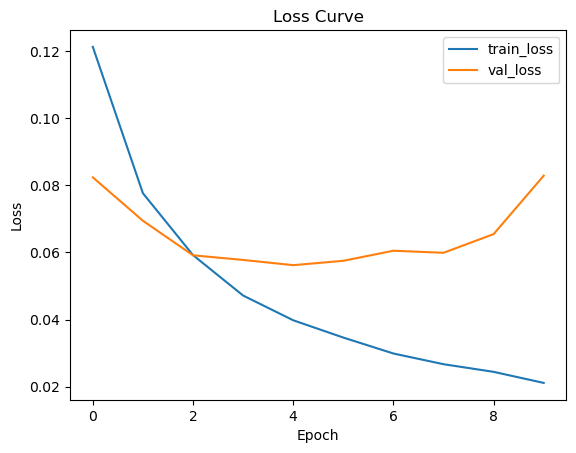

In [117]:
#Plot Training Curves
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [118]:
#Deep Model Evaluation
y_prob_dl = model.predict(X_test_pad, verbose=0)
y_pred_dl = (y_prob_dl >= 0.5).astype(int)

print("===== DEEP LEARNING (BiLSTM) =====")
print("Macro F1:", f1_score(y_test, y_pred_dl, average="macro"))

===== DEEP LEARNING (BiLSTM) =====
Macro F1: 0.5793694950502037


In [119]:
print("\nPer-label report:")
print(classification_report(y_test, y_pred_dl, target_names=LABELS, zero_division=0))


Per-label report:
               precision    recall  f1-score   support

        toxic       0.74      0.79      0.76      2260
 severe_toxic       0.38      0.59      0.46       225
      obscene       0.81      0.77      0.79      1279
       threat       0.33      0.40      0.36        53
       insult       0.70      0.65      0.67      1192
identity_hate       0.41      0.44      0.43       227

    micro avg       0.70      0.72      0.71      5236
    macro avg       0.56      0.61      0.58      5236
 weighted avg       0.71      0.72      0.72      5236
  samples avg       0.06      0.07      0.06      5236



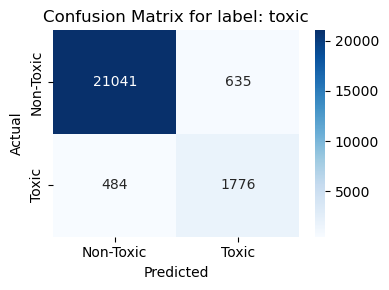

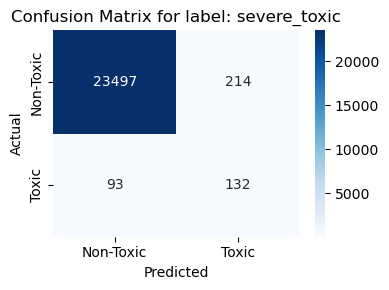

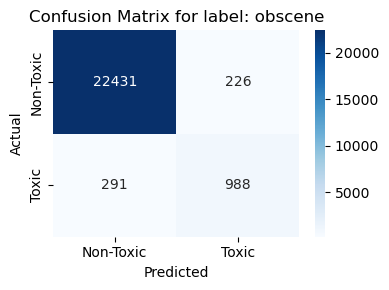

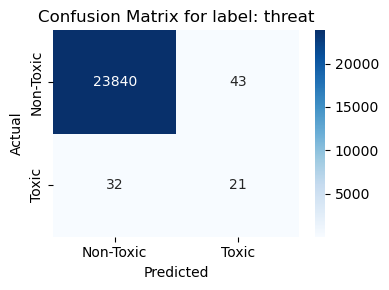

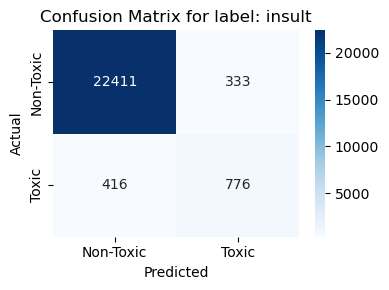

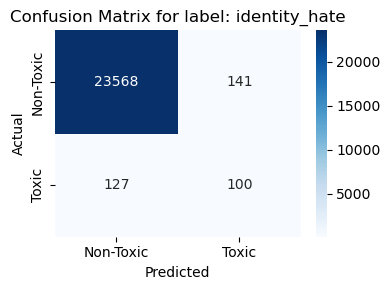

In [120]:
#Confusion Matrix per Label (Error Analysis)
y_true = y_test
y_pred = y_pred_dl   # use deep learning predictions

for i, label in enumerate(LABELS):
    cm = confusion_matrix(y_true[:, i], y_pred[:, i])
    
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Toxic', 'Toxic'],
                yticklabels=['Non-Toxic', 'Toxic'])
    
    plt.title(f"Confusion Matrix for label: {label}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

In [121]:
# Create a DataFrame for analysis
analysis_df = pd.DataFrame({
    "text": X_test,
})

for i, label in enumerate(LABELS):
    analysis_df[label] = y_true[:, i]
    analysis_df[f"pred_{label}"] = y_pred[:, i]

# Show some errors for each label
for label in LABELS:
    print("\n==============================")
    print(f"Misclassified examples for label: {label}")
    print("==============================")
    
    # False Negatives (missed toxic)
    fn = analysis_df[(analysis_df[label] == 1) & (analysis_df[f"pred_{label}"] == 0)]
    print("\nFalse Negatives (missed toxic):")
    display(fn[["text"]].head(3))
    
    # False Positives (wrongly flagged)
    fp = analysis_df[(analysis_df[label] == 0) & (analysis_df[f"pred_{label}"] == 1)]
    print("\nFalse Positives (wrongly flagged):")
    display(fp[["text"]].head(3))



Misclassified examples for label: toxic

False Negatives (missed toxic):


,text
38,please write silly perhaps one told youre obvi...
63,sockpuppet oh stifle think ive worked hard don...
65,youre dumb american right degree know nothing ...



False Positives (wrongly flagged):


,text
79,far honest bloated article oh disagreement cen...
128,scientifically proven epitome arsehole stretch...
170,maybe wrong shouldnt created one group woman d...



Misclassified examples for label: severe_toxic

False Negatives (missed toxic):


,text
1082,go fuck pathetic censorship dictator wannabe
1357,dare vandalize talk page faggot fuck
1383,whoever deletes shit wikipedia small dick lose...



False Positives (wrongly flagged):


,text
26,renzoy shut fuck
167,listen go fuck asswipe
284,p im fucking cunt rag enjoy taste nice warm pi...



Misclassified examples for label: obscene

False Negatives (missed toxic):


,text
84,gay douche like gay porno ahaghagagagaa
127,oak homophobia provided full citation prof oak...
334,ok really dont understand youve gone tagged im...



False Positives (wrongly flagged):


,text
40,hi kannadiga shame look like terrible as false...
311,fail see problem edit summary quote talk page ...
364,lulz hahahahahaha



Misclassified examples for label: threat

False Negatives (missed toxic):


,text
373,honesty fuck adeputs mechanicus page typed mac...
798,man shot war crime murder
1591,bigger bang tour memorable moment remove memor...



False Positives (wrongly flagged):


,text
1001,fuck rape kid fenian bogtrotting shit hope one...
1317,driven away die
1509,whoever said people arab homosexual bad thing ...



Misclassified examples for label: insult

False Negatives (missed toxic):


,text
334,ok really dont understand youve gone tagged im...
411,plain fanatic stupid stupid herd member victim...
431,name person paranoid idiot put claim say matter



False Positives (wrongly flagged):


,text
259,blatant pov pushing neither guy made contribut...
291,hey r douche
311,fail see problem edit summary quote talk page ...



Misclassified examples for label: identity_hate

False Negatives (missed toxic):


,text
21,worry use another account stop wikipedia stop ...
227,fred shut sad old twat one interested think im...
624,nick gas coming back coming uk cyphoidbomb gay...



False Positives (wrongly flagged):


,text
39,youre jerk youre jerk youre jerk youre jerk yo...
167,listen go fuck asswipe
230,take suck big black donkey ball


In [122]:
#Threshold Tuning
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
results = []

for t in thresholds:
    preds = (y_prob_dl >= t).astype(int)
    f1 = f1_score(y_test, preds, average='macro')
    results.append((t, f1))

pd.DataFrame(results, columns=["Threshold", "Macro_F1"])

,Threshold,Macro_F1
0,0.3,0.574699
1,0.4,0.582189
2,0.5,0.579369
3,0.6,0.572714
4,0.7,0.550766


In [123]:
#Save Deep Model + Tokenizer + Predictions
model.save("outputs/bilstm_toxic_model.keras")

# Save tokenizer
tokenizer_json = tokenizer.to_json()
with open("outputs/tokenizer.json", "w", encoding="utf-8") as f:
    f.write(tokenizer_json)

# Save deep predictions
dl_pred_df = pd.DataFrame(y_pred_dl, columns=[f"pred_{c}" for c in LABELS])
dl_pred_df.to_csv("outputs/deep_predictions.csv", index=False)

print("Saved deep learning artifacts to outputs/")

Saved deep learning artifacts to outputs/


In [124]:
#PART C: Compare Baseline vs Deep (Phase II Nice Table)

In [125]:
#Comparison Table
baseline_f1 = f1_score(y_test, y_pred_base, average="macro")
deep_f1 = f1_score(y_test, y_pred_dl, average="macro")

compare = pd.DataFrame({
    "Model": ["TF-IDF + LogisticRegression", "BiLSTM (Deep Learning)"],
    "Macro_F1": [baseline_f1, deep_f1]
})

compare

,Model,Macro_F1
0,TF-IDF + LogisticRegression,0.534418
1,BiLSTM (Deep Learning),0.579369
